In [1]:
import csv
import datetime
import time
import os
from selenium import webdriver

import matplotlib.pyplot as plt
import collections
from openpyxl import load_workbook

import math
import statistics
import numpy as np
import pandas as pd

import openpyxl
openpyxl.Workbook.encoding = "cp936"


In [36]:
def get_filename_from_folder(folder_path, ext=""):
    file_name_list = []
    for file_name in os.listdir(folder_path):
        name = os.path.join(folder_path + "/"+ file_name)
        
        # get file extension
        file_ext = os.path.splitext(file_name)[1]
        # if user give ext and the file extension is not the same, pass
        if ext and file_ext != ext:
            continue
        
        # os.rename(name, os.path.join(folder_path + "/"+ file_name[1:]))
#         
        file_name_list.append(name)
        
    return sorted(file_name_list)

def filename_process(target, filename_list):
    
    split_file_name = [ x.split("_") for x in filename_list]
    
    for i in split_file_name:
        try:
            ytr = i[1][1:]
            types = i[3]
            start = i[4]
            end = i[5].split(".")[0]
        
            if target == ytr:
                yield ytr, types, start, end
        except:
            pass

def get_file_by_ytr_and_date(ytr, types, start, filename_list):
    file_list = []
    for fytr, ftypes, fstart, fend in filename_process(ytr, filename_list):
        if fytr == ytr and ftypes == types and fstart == start:
            name = f"./yt_/{fytr}_單主題_{ftypes}_{fstart}_{fend}.xlsx"
            file_list.append(name)
    return file_list


def string_to_datetime(s):
    return datetime.datetime.strptime(s, '%Y/%m/%d')


# opview 資料（趨勢 和 好感度）
def get_ytrs_view_and_emotion_by_startdate(ytrs: list, startdate: str, enddate: str, filename_list_op: list):
    
    ytrs_view = []
    ytrs_emotion = []
    for ytr in ytrs:
        for filename in get_file_by_ytr_and_date(ytr, '趨勢', DATE, filename_list_op):
            wb = load_workbook(filename=filename)
            op_view_data = collections.OrderedDict()
            # op_view_data['name'] = ytr
            opview_wb = wb['日趨勢']
            for i in range(2, opview_wb.max_row+1):
                day = opview_wb.cell(column=1, row=i).value
                qty = opview_wb.cell(column=2, row=i).value
                
                if day >= startdate and day <= enddate:
                    op_view_data[day] = qty

            ytrs_view.append(op_view_data)
        
        for filename in get_file_by_ytr_and_date(ytr, '情緒', DATE, filename_list_op):
            # opview 資料（情緒）
            wb = load_workbook(filename=filename)
            op_view_emotion = collections.OrderedDict(
                {'good': collections.OrderedDict(), 'bad': collections.OrderedDict()})
            # op_view_emotion['name'] = ytr
            opview_wb = wb['日情緒趨勢']
            for i in range(2, opview_wb.max_row+1):

                day = opview_wb.cell(column=1, row=i).value
                good = opview_wb.cell(column=2, row=i).value
                bad = opview_wb.cell(column=3, row=i).value
                total = opview_wb.cell(column=4, row=i).value
                if day >= startdate and day <= enddate:
                    op_view_emotion["good"][day] = good
                    op_view_emotion["bad"][day] = bad

            ytrs_emotion.append(op_view_emotion)
    return ytrs_view ,ytrs_emotion

# plot views and good/bad emotions


def plot_view_and_emotion(ytrs_view, ytrs_emotion, ytrs, stepsize=1, figsize=(19,4)):
    stepsize = 1
    for view, emotion, name in zip(ytrs_view, ytrs_emotion, ytrs):
        print(name)
        fig, ax1 = plt.subplots(figsize=figsize)
        ax1.plot(view.values(), figure=fig,
                 linewidth=1, c='black', label="opview")
        ax1.plot(emotion["good"].values(), figure=fig,
                 linewidth=1, c='g', label="good")
        ax1.plot(emotion["bad"].values(), figure=fig,
                 linewidth=1, c='r', label="bad")
        plt.xticks(range(0, len(list(view.values())), stepsize),
                   list(view.keys())[::stepsize], rotation=20)
        ax1.legend()
        plt.show()


def get_news_filename_list_by_ytrs(ytrs, data_folder_path, include_news=["ettoday_keywords.csv", "apple_news.csv", "dcard.csv" "ettoday_tag.csv", "ptt.csv"]):
    filename_list_news_all = []

    for ytr in ytrs:
        print(ytr)
        ytr_news = []  # news list for each ytr
        filename_list_news = get_filename_from_folder(
            data_folder_path + ytr)
        for x in filename_list_news:
            if x.split('/')[-1] in include_news:
                ytr_news.append(x)
        filename_list_news_all.append(ytr_news)

    return filename_list_news_all


def get_news_list_by_filename_list(filename_list_news_et):
    news_list = []
    for filename_list in filename_list_news_et:  # iterate ytr
        news = []
        for filename in filename_list:
            with open(filename, encoding="utf-8") as f:
                reader = csv.reader(f)
                for idx, row in enumerate(reader):
                    # Source,Title,Link,Date,Summary,Text,Like

                    if idx == 0 or row == ['Source', 'Title', 'Link', 'Date', 'Summary', 'Text', 'Like']:
                        continue
                    Source = row[0]
                    Title = "".join(row[1].split())
                    Link = row[2]
                    Date = row[3].split(" ")[0].replace('-', '/')
                    Summary = "".join(row[4].split())
                    Text = row[5]

                    news.append({"source": Source, "title": Title, "link": Link,
                                 "date": Date, "summary": Summary, "text": Text})
        news_list.append(news)
    return news_list


def compare_news_list_and_event_list(multiply=3):
    print('單日大於', multiply, '倍過去七天的平均：')

    # event definition
    for view, emotion, name, news in zip(ytrs_view, ytrs_emotion, ytrs, news_list):
        
        print(name)
        # event definition
        data = [list(view.values())[0]] * 7
        data.extend(list(view.values()))

        count = 0
        event_list = []

        for i, d in enumerate(data[7:], start=7):
            seven_day = data[i-7:i]
            seven_day_avg = sum(seven_day)/7
            if d > multiply * seven_day_avg:
                day = list(view.keys())[i-7]
                event_list.append(day)
        print(event_list)

        # find news
        print('來源     事件日期      日期好壞比  新聞日期     新聞日期好壞比    新聞標題')
        for i in news:
            day_add = datetime.timedelta(days=2)
            try:
                news_date = string_to_datetime(i['date'])
                
            except:
                news_date = i['date'].split(" ")[0].replace("-", "/")
                news_date = string_to_datetime(news_date)

            for event in event_list:
                temp_event = event
                temp_view = view
                temp_emotion = emotion
                event_day = string_to_datetime(event)
                if news_date >= event_day and news_date <= event_day + day_add:
                    try:
                        print(i['source'], event_day.strftime('%Y-%m-%d'), ' ',
                            '%.2f' % (round(
                                emotion['good'][event] / emotion['bad'][event], 2)), '    ',
                            news_date.strftime('%Y-%m-%d'), '  '
                            '%.2f' % (round(
                                emotion['good'][i['date']] / emotion['bad'][i['date']], 2)), '       ',
                            i['title'])
                    except:
                        pass


In [11]:
filename_list_op = get_filename_from_folder("./yt_")
filename_list_op[0]

'./yt_/Dr.Ivan_單主題_來源_20191201_20201231.xlsx'

## opview plot

/Users/bobo/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


放火


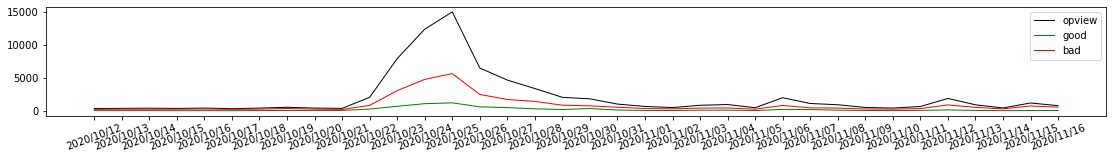

Joeman


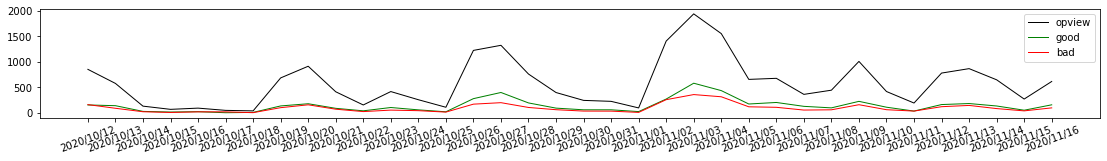

Toyz


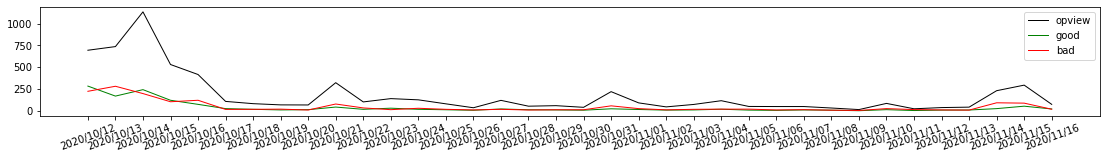

NanaQ


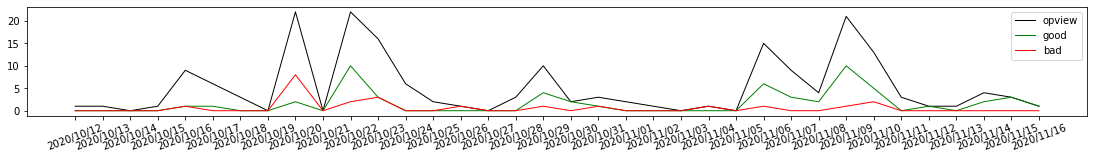

呱吉


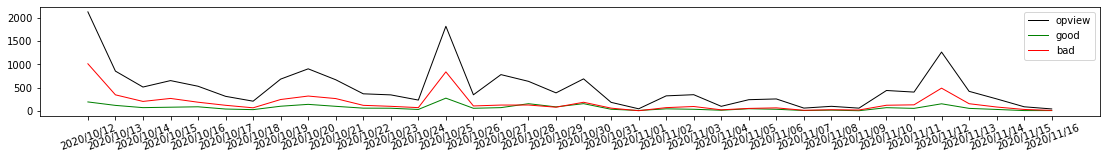

In [19]:
ytrs = ["放火", "Joeman", "Toyz", "NanaQ", "呱吉"]
DATA_FOLDER_PATH = "/Users/bobo/OneDrive - 台灣微軟/0. bobo/Codes/crawlers/data/"
DATE = "20191201"
STARTDATE = "2020/10/12"
# STARTDATE = "20200201"
ENDDATE = "2020/11/16"
ytrs_view, ytrs_emotion = get_ytrs_view_and_emotion_by_startdate(
    ytrs, STARTDATE, ENDDATE, filename_list_op)
plot_view_and_emotion(ytrs_view, ytrs_emotion, ytrs, stepsize=1, figsize=(19,2))


## read news

In [40]:
ytrs = ["放火 Louis", "Joeman", "Toyz", "NanaQ", "呱吉"]
filename_list_news = get_news_filename_list_by_ytrs(ytrs, DATA_FOLDER_PATH, ["ettoday_keywords.csv", "apple_news.csv", "dcard.csv" "ettoday_tag.csv", "ptt.csv"])
news_list = get_news_list_by_filename_list(filename_list_news)
compare_news_list_and_event_list(multiply=3)

放火 Louis
Joeman
Toyz
NanaQ
呱吉
單日大於 3 倍過去七天的平均：
放火 Louis
['2020/10/22', '2020/10/23', '2020/10/24', '2020/10/25']
來源     事件日期      日期好壞比  新聞日期     新聞日期好壞比    新聞標題
apple_news 2020-10-24   0.23      2020-10-26   0.24         放火桃花劫後恢復影片更新「不會做任何傷害自己的事」
apple_news 2020-10-25   0.21      2020-10-26   0.24         放火桃花劫後恢復影片更新「不會做任何傷害自己的事」
apple_news 2020-10-25   0.21      2020-10-27   0.28         燒單車灼傷小學童放火國中生到案！惡行動機曝光
apple_news 2020-10-25   0.21      2020-10-27   0.28         放火桃花劫稱問心無愧「擔心會不會有人找我跟家人麻煩」
apple_news 2020-10-25   0.21      2020-10-27   0.28         為「放火」桃花劫互槓瘋男怒嗆烏鴉：你曝光後害他黑掉
apple_news 2020-10-25   0.21      2020-10-27   0.28         「生子無用」翁燒兒遊覽車
apple_news 2020-10-24   0.23      2020-10-26   0.24         老父怨「養子無路用」縱火燒子遊覽車兩子聲請保護令（台語片）
apple_news 2020-10-25   0.21      2020-10-26   0.24         老父怨「養子無路用」縱火燒子遊覽車兩子聲請保護令（台語片）
apple_news 2020-10-24   0.23      2020-10-26   0.24         全球聲援籲中釋放12港青
apple_news 2020-10-25   0.21      2020-10-26   0.24         全球聲援籲中釋放12港青
apple_news 

單日大於 3 倍過去七天的平均：
放火 Louis
['2020/10/22', '2020/10/23', '2020/10/24', '2020/10/25']
來源     事件日期      日期好壞比  新聞日期     新聞日期好壞比    新聞標題
apple_news 2020-10-24   0.23      2020-10-26   0.24         放火桃花劫後恢復影片更新「不會做任何傷害自己的事」
apple_news 2020-10-25   0.21      2020-10-26   0.24         放火桃花劫後恢復影片更新「不會做任何傷害自己的事」
apple_news 2020-10-25   0.21      2020-10-27   0.28         燒單車灼傷小學童放火國中生到案！惡行動機曝光
apple_news 2020-10-25   0.21      2020-10-27   0.28         放火桃花劫稱問心無愧「擔心會不會有人找我跟家人麻煩」
apple_news 2020-10-25   0.21      2020-10-27   0.28         為「放火」桃花劫互槓瘋男怒嗆烏鴉：你曝光後害他黑掉
apple_news 2020-10-25   0.21      2020-10-27   0.28         「生子無用」翁燒兒遊覽車
apple_news 2020-10-24   0.23      2020-10-26   0.24         老父怨「養子無路用」縱火燒子遊覽車兩子聲請保護令（台語片）
apple_news 2020-10-25   0.21      2020-10-26   0.24         老父怨「養子無路用」縱火燒子遊覽車兩子聲請保護令（台語片）
apple_news 2020-10-24   0.23      2020-10-26   0.24         全球聲援籲中釋放12港青
apple_news 2020-10-25   0.21      2020-10-26   0.24         全球聲援籲中釋放12港青
apple_news 2020-10-24   0.23      2020-10